# Linear Regression

# 1. Concepts

Simple Linear Regression

Unknown Model: $y = \beta_0 + \beta_1.X_1 + \epsilon$ 

LR Model: $\hat y = \hat \beta_0 + \hat  \beta_1.X_1$ 


$\hat \beta = (X^T.X)^{-1}.X^T.Y$

# 2. Imports

In [151]:
library(stats)
library(tidyverse)
library(ggplot2)
library(dplyr)
library(corrplot)
library(broom)
library(ggpubr)

# 3. Loading Dataset

In [195]:
df = read.csv("../data/regression_cuboulder_TwitterData.csv", sep = ",")
# colnames(df) = c("Y", "X")
# df = df[,c(2,1)]
head(df, 10)

,User_FollowersCount_log,User_AverageTweetClickThroughRate
,<dbl>,<dbl>
1,5.308268,7.833996
2,5.308268,7.833996
3,8.486734,6.650279
4,5.308268,7.833996
5,6.393591,5.433722
6,6.267201,8.323608
7,5.817111,5.627621
8,7.184629,7.104144
9,6.173786,6.054439


- Here, X and Y are tweets analytics suchs natural log of follower counts and average click through rate per tweet by followers.

# 4. Exploratory data analysis for Regression

Before we model the data, let's first explore the data. We'll first check to see whether there are any missing values in the dataset. Then, we'll take a look at some univariate and bivariate summaries of the data.

Some general requirements for Regression Analytics:

1. Missing Values Treatment: Imputation using mean of features.


2. Distribution Analysis: For checking on skewness (Histograms)


3. Outlier Detection: Detect outliers and either drop them or inlvolve them.


4. Correlation Plot: To measure strength of correlation between variables.


5. Scatter Plot: To measure correlation relationship between Response vs predictor, and among predictors.

In [153]:
summary(df)

 User_FollowersCount_log User_AverageTweetClickThroughRate
 Min.   : 0.000          Min.   : 0.000                   
 1st Qu.: 5.782          1st Qu.: 6.603                   
 Median : 6.796          Median : 7.814                   
 Mean   : 6.554          Mean   : 7.831                   
 3rd Qu.: 7.412          3rd Qu.: 9.059                   
 Max.   :11.399          Max.   :13.892                   

- There are no abnormalities, or noise in the dataset. There is a zero for Facebook Sales but it could be valid figure and not a missing imputation. So we could proceed with this dataset.

### 1. Missing data

Are there any missing values coded as NA? Or, are there any odd values for variables, e.g., 9999 or 0 possibly standing in for a missing value?

In [154]:
# Count missing values:
missing_values <- sapply(df, function(x) sum(is.na(x)))
print(missing_values)

          User_FollowersCount_log User_AverageTweetClickThroughRate 
                                0                                 0 


- No missing values in any of the feature.

### 2. Distribution Analysis

#### Histograms

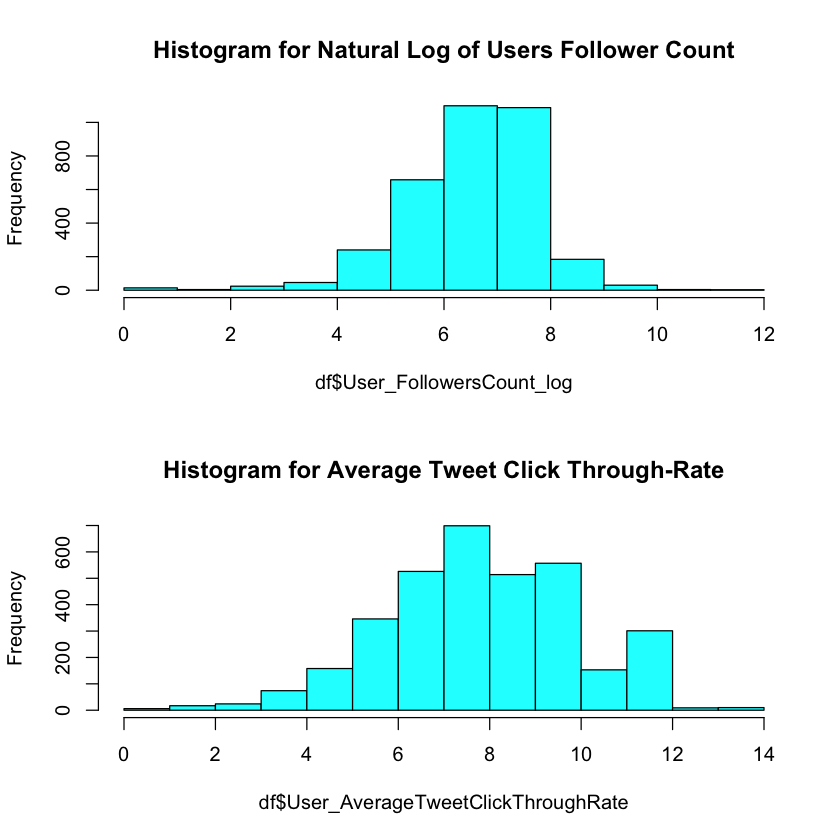

In [155]:
par(mfrow = c(2, 1))
hist(df$User_FollowersCount_log, col="cyan", main = "Histogram for Natural Log of Users Follower Count")
hist(df$User_AverageTweetClickThroughRate , col="cyan", main = "Histogram for Average Tweet Click Through-Rate")

#### Boxplots

As you may have noticed from the histogram of `newspaper`, there may be a few **outliers**. Let's look at some boxplots to see in further detail. Note that R classifies potential outliers by the "IQR criterion". 

This criterion means that all observations above $q_{0.75}+1.5\times IQR$ or below $q_{0.25}-1.5\times IQR$ are classified as outliers, where

$q_{0.25}$ is the first quartile;

$q_{0.75}$ is the third quartile.

IQR is the interquartile range, defined as the difference between the third and first quartile.

A boxplot will "flag" the outliers. Construct a boxplot for each variable and comment on the existence of potential outliers.

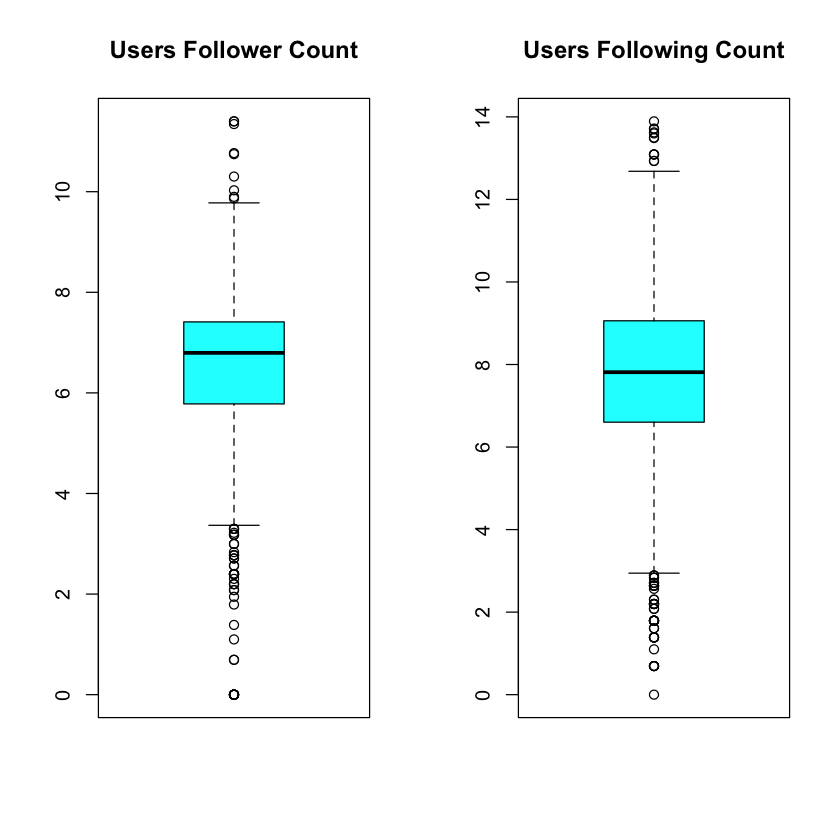

In [156]:
par(mfrow = c(1, 2))
boxplot(df$User_FollowersCount_log, col="cyan", main = "Users Follower Count")
boxplot(df$User_AverageTweetClickThroughRate , col="cyan", main = "Users Following Count")

As we know, any value

- above Quartile_3 + 1.5IQR or lower than Quartile_1 - 1.5IQR could be classified as an outlier
- Indicating User_FollowersCount_log has couple of outliers.

----
----

# 5. Train - Test Split

In [167]:
set.seed(7)

sample <- sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(0.75,0.2))
train  <- df[sample, ]
test   <- df[!sample, ]

cat("Number of records in Training set:", nrow(train))
cat("\nNumber of records in Testing set:", nrow(test))

Number of records in Training set: 2674
Number of records in Testing set: 720

In [199]:
head(train, 5)

,User_FollowersCount_log,User_AverageTweetClickThroughRate
,<dbl>,<dbl>
2,5.308268,7.833996
3,8.486734,6.650279
4,5.308268,7.833996
5,6.393591,5.433722
7,5.817111,5.627621


In [198]:
head(test, 5)

,User_FollowersCount_log,User_AverageTweetClickThroughRate
,<dbl>,<dbl>
1,5.308268,7.833996
6,6.267201,8.323608
8,7.184629,7.104144
19,7.748029,7.392032
23,7.136483,7.358831


----
----

# 6. Linear Regression Modelling

In [168]:
# Plot Functions for Simple Linear Regression Analysis
# Y = beta_0 = beta_1.X

#############################################################################
#      Simple Linear Regression with X,Y
#
#  > plot_slr(X=marketing$facebook, Y=marketing$sales)
#############################################################################
plot_slr <- function(X,Y) {
    data = data.frame(x=X, y=Y)
    ggplot(data, aes(x=x, y=y))+
        geom_point() +
        geom_smooth(method="lm", col="red") +
        stat_regline_equation(label.x = 0, label.y = 0) +
        labs(title = "Simple Linear Regression", x = "X Predictor", y = "Y Response")
}

#############################################################################
#      Simple Linear Regression with fitted lm()
#
#  > plot_slr_model(slr_lm_model)
#############################################################################
plot_slr_model <- function(lm_model) {
    if(length(lm_model$coeff) == 2){
        ggplot(lm_model$model, aes_string(x = names(lm_model$model)[2], y = names(lm_model$model)[1])) + 
          geom_point() +
          stat_smooth(method = "lm", col = "blue") +
          labs(title = paste(
              "\n R2 = ", round(summary(lm_model)$r.squared, 5),
              "\n Adj R2 = ", round(summary(lm_model)$adj.r.squared, 5),
              "\n Intercept =", round(lm_model$coef[[1]],5 ),
              "\n Slope =", round(lm_model$coef[[2]], 5),
              "\n P =", round(summary(lm_model)$coef[2,4], 5)))
    } 
    else{
        print("Invalid LR model - pass a Simple LR model only.")
    }
}

#############################################################################
#      Simple Linear Regression with given beta0, beta1
#
#  > plot_slr_coeff(X=marketing$facebook, Y=marketing$sales, beta_0, beta_1)
#############################################################################
plot_slr_coeff <- function(X, Y, beta_0, beta_1) {
    data = data.frame(x=X, y=Y)
    ggplot(data = data, aes(x = x, y = y)) +
        geom_point() +
        geom_abline(intercept = beta_0, slope = beta_1, col="blue")
}

## Simple Linear Regression


Modelling Equation:

User_AverageTweetClickThroughRate(Y) = $\beta_0 + \beta_1.$User_FollowersCount_log(X) $ + \space \epsilon$

Where:
- Y: Dependent Variable or Response
- X: Independent Variable or Feature
- $\beta_0$ : Intercept Parameter
- $\beta_1$ : Slope Parameter

In [169]:
# Simple Linear Regression

n = nrow(train)
p = ncol(train) - 1         # minus the Response column
cat("Records n = ", n, "\npredictors p = ", p, "\nD.o.f (n - p -1) = ", n-p-1)

# SLR
lm_twitter = lm(User_AverageTweetClickThroughRate ~ User_FollowersCount_log, data=train)
summary(lm_twitter)

Records n =  2674 
predictors p =  1 
D.o.f (n - p -1) =  2672


Call:
lm(formula = User_AverageTweetClickThroughRate ~ User_FollowersCount_log, 
    data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.4244 -1.1672 -0.1728  0.6933  7.8492 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              2.52281    0.18402   13.71   <2e-16 ***
User_FollowersCount_log  0.81495    0.02755   29.58   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.785 on 2672 degrees of freedom
Multiple R-squared:  0.2467,	Adjusted R-squared:  0.2464 
F-statistic: 875.1 on 1 and 2672 DF,  p-value: < 2.2e-16


The simple linear regression was modelled on the Twitter Data, where the predictor was taken as the number of followers a user has and the target was chosen as the average click-through-rate or the average popularity of the tweets the user gains for each tweet.


For this SLR model, the project aims to reason and identify if for a given user followers count, and taking it's natural log, could the model predict the user's average popularity for a tweet, holding others variables constant.


- As per the model summary, it's visible and the individual t-Test, the p-value is signifincalty lower than the level of signicance (alpha 0.05, two-tail t-Test), thus, we reject the Null Hypothesis which had stated that the predictor is not required, i.e. parameter of the predictor is not different than zero. Thus, it can be concluded that the predictor is essential in modelling this relationship.


- The R-Squared value is rather low indicating there could be multiple predictors which can explain the variability in the response better.


- As per the F-Test, and it's p-value, which is significantly lower than level of significance, and thus we can reject the f-Stat Null Hypothesis which had stated that the reduced model (null-model) would be sufficient to explain the variations in the data. Thus it can be concluded that, this model fits well, and the predictor is essential in modelling this relationship. 

### SLR Plot

`geom_smooth()` using formula = 'y ~ x'


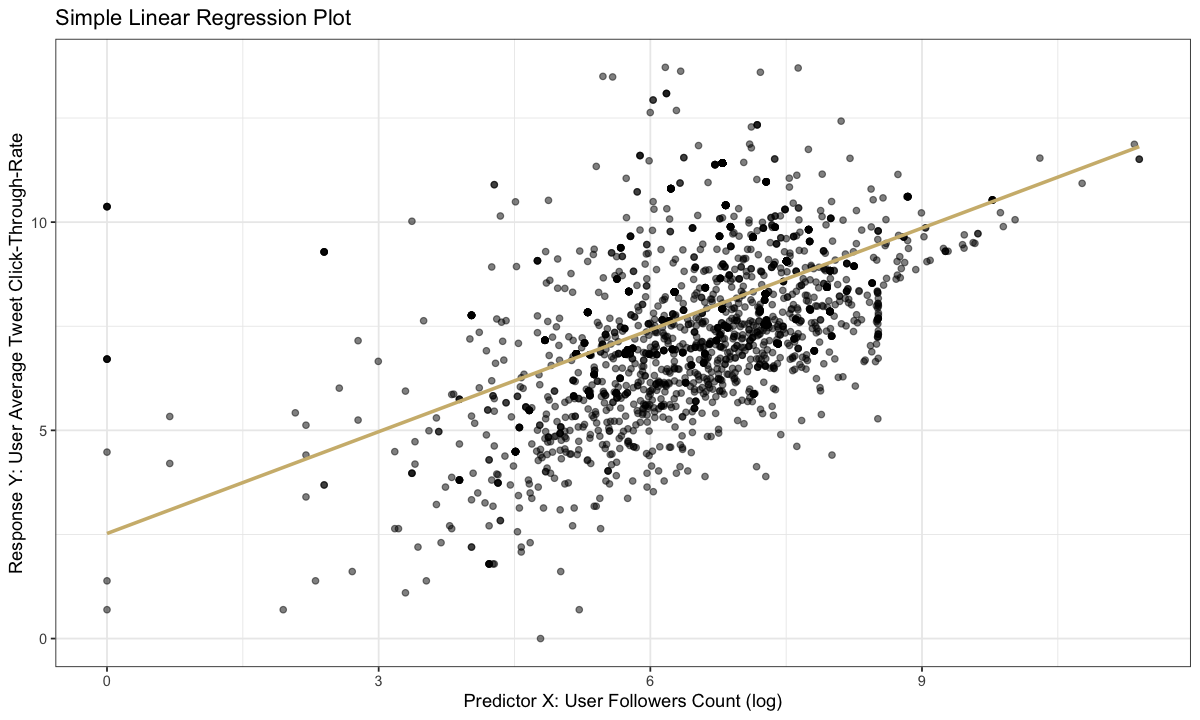

In [191]:
options(repr.plot.width=10, repr.plot.height=6)
ggplot(train, aes(x=User_FollowersCount_log, y=User_AverageTweetClickThroughRate)) + 
    geom_point(alpha = 0.5) + 
    geom_smooth(method = lm, se=FALSE, col="#CFB87C") + 
    xlab("Predictor X: User Followers Count (log)") + 
    ylab("Response Y: User Average Tweet Click-Through-Rate") +
    ggtitle("Simple Linear Regression Plot") +
    theme_bw()

The SLR best-fit line seems to do a decent job. There are a handful of outliers in the data and the ones in the later half, tend to be influential ones.

For this SLR model, the project aims to reason and identify if for a given user followers count, and taking it's natural log, could the model predict the user's average popularity for a tweet, holding others variables constant.

It turns out, Yes the SLR model can.

### Making Predictions: Prediction vs Explanation

### A). Training Data Prediction


- Predicting on Training dataset (aka. Explainability, or fitted)


- n = number of training samples


- $Y = True \space Train \space response$


- $\widehat Y = Train \space Prediction$


- $Metrics: \space MSE, \space RMSE, \space MAE, \space R_2, \space Adjusted.R_2$

In [176]:
#### Predictions - Train ####

# train samples
n = nrow(train)

# true values for train data
y = train$User_AverageTweetClickThroughRate

# predictions over train data
y_hat = predict(lm_twitter) # or use, fitted(lm_marketing)


## Metrics
residuals = sum(y - y_hat)               # OR, residuals = sum(residuals(lm_marketing))
rss = sum((y - y_hat)^2)
ess = sum((y_hat - mean(y))^2)
tss = sum((y - mean(y))^2)
mse = 1/n * sum((y - y_hat)^2)
rmse = sqrt(mse)
mae = 1/n * sum(abs(y - y_hat))
r2 = 1 - rss/tss

# Adjusted R Squared
# - beacuse if we increase p (num of predictors), R2 will keep on increasing, so we add penalty!
# n = dim(adv)[1], p = 3
adj.r2 = 1 - ((1-r2) * (n-1))/(n-p-1)

cat("Explainable Results (Training Data Prediction) :\n\n")
cat("SR   : Sum of Residuals/Errors   : ", residuals)
cat("\nRSS  : Residual Sum of Squares   : ", round(rss,3))
cat("\nESS  : Explained Sum of Squares  : ", round(ess,3))
cat("\nTSS  : Total Sum of Squares      : ", round(tss,3))
cat("\nMSE  : Mean Squared Error        : ", round(mse,3))
cat("\nRMSE : Root Mean Squared Error   : ", round(rmse,3))
cat("\nMAE  : Mean Absolute Error       : ", round(mae,3))
cat("\nR2   : R2 Squared                : ", round(r2,3))
cat("\nA.R2 : Adjusted R2 Squared       : ", round(adj.r2,3))

Explainable Results (Training Data Prediction) :

SR   : Sum of Residuals/Errors   :  1.190528e-10
RSS  : Residual Sum of Squares   :  8515.551
ESS  : Explained Sum of Squares  :  2788.907
TSS  : Total Sum of Squares      :  11304.46
MSE  : Mean Squared Error        :  3.185
RMSE : Root Mean Squared Error   :  1.785
MAE  : Mean Absolute Error       :  1.362
R2   : R2 Squared                :  0.247
A.R2 : Adjusted R2 Squared       :  0.246

### B). Testing Data Prediction


- Predicting on testing dataset (aka. Prediction)


- k = number of testing samples


- $Y^\star = True \space test \space response$


- $\widehat Y^\star = Test \space Prediction$


- $Metrics: \space MSPE, \space RMSPE, \space MAPE, \space R_2, \space Adjusted.R_2$

In [180]:
## Test Predictions - Test ##

# test samples          *** important - should be number of test samples ***
k = nrow(test)

# true values for test data
y_star = test$User_AverageTweetClickThroughRate

# predictions over test data
y_hat_star = predict(lm_twitter, newdata = test)

## Test Metrics
residuals = sum(y_star - y_hat_star)
rss = sum((y_star - y_hat_star)^2)
ess = sum((y_hat_star - mean(y_star))^2)
tss = sum((y_star - mean(y_star))^2)
mspe = 1/k * sum((y_star - y_hat_star)^2)
rmspe = sqrt(mse)
mape = 1/k * sum(abs(y_star - y_hat_star))
r2 = 1 - rss/tss

# Adjusted R Squared
# - beacuse if we increase p (num of predictors), R2 will keep on increasing, so we add penalty!
# n = dim(adv)[1], p = 3
adj.r2 = 1 - ((1-r2) * (k-1))/(k-p-1)

cat("Prediction Results (Testing Data Prediction) :\n\n")
cat("SR     : Sum of Residuals/Errors               : ", residuals)
cat("\nRSS    : Residual Sum of Squares               : ", round(rss,3))
cat("\nESS    : Explained Sum of Squares              : ", round(ess,3))
cat("\nTSS    : Total Sum of Squares                  : ", round(tss,3))
cat("\nMSPE   : Mean Squared Prediction Error         : ", round(mspe,3))
cat("\nRMSPE  : Root Mean Squared Predicition Error   : ", round(rmspe,3))
cat("\nMAPE   : Mean Absolute Prediction Error        : ", round(mape,3))
cat("\nR2     : R2 Squared                            : ", round(r2,3))
cat("\nA.R2   : Adjusted R2 Squared                   : ", round(adj.r2,3))

Prediction Results (Testing Data Prediction) :

SR     : Sum of Residuals/Errors               :  -110.2369
RSS    : Residual Sum of Squares               :  2050.859
ESS    : Explained Sum of Squares              :  754.95
TSS    : Total Sum of Squares                  :  2977.449
MSPE   : Mean Squared Prediction Error         :  2.848
RMSPE  : Root Mean Squared Predicition Error   :  1.785
MAPE   : Mean Absolute Prediction Error        :  1.318
R2     : R2 Squared                            :  0.311
A.R2   : Adjusted R2 Squared                   :  0.31

---
---